# RobustOps: CI/CD-Integrated Adversarial Robustness Testing & ML Risk Scoring

**INSE 6450 — AI in Systems Engineering | Winter 2026**
**Cynthia Musila — 40311473**

**GitHub**: https://github.com/CynthiaK1/INSE-6450

---

This notebook runs the entire RobustOps pipeline end-to-end:
1. **Train** a ResNet-18 on CIFAR-10
2. **Attack** the model with FGSM and PGD
3. **Generate** adversarial evaluation telemetry
4. **Engineer** robustness features
5. **Score** risk and enforce deploy/block gates
6. **Visualize** all EDA plots



## 0. Setup & Imports

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# Create output directories
os.makedirs("data", exist_ok=True)
os.makedirs("outputs/plots", exist_ok=True)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU: Tesla T4


## 1. Configuration

In [2]:
# All configurable parameters in one place
CONFIG = {
    "model": {
        "architecture": "resnet18",
        "num_classes": 10,
        "checkpoint_path": "outputs/resnet18_cifar10.pth",
    },
    "data": {
        "data_dir": "data/",
        "batch_size": 128,
        "num_workers": 2,
    },
    "attacks": [
        {"type": "fgsm", "epsilons": [0.01, 0.02, 0.04, 0.08]},
        {"type": "pgd", "epsilons": [0.01, 0.02, 0.04, 0.08], "pgd_steps": 10, "pgd_alpha": 0.005},
    ],
    "risk_scoring": {
        "weights": {
            "accuracy_drop": 0.35,
            "confidence_drop": 0.25,
            "attack_success_rate": 0.25,
            "worst_class_asr": 0.15,
        },
        "deploy_threshold": 0.5,
    },
    "outputs": {
        "telemetry_path": "outputs/adversarial_telemetry.csv",
        "features_path": "outputs/robustness_features.csv",
        "risk_report_path": "outputs/risk_report.csv",
        "plots_dir": "outputs/plots/",
    },
}

print("Configuration loaded.")
print(f"Attacks: {[a['type'] for a in CONFIG['attacks']]}")
print(f"Epsilons: {CONFIG['attacks'][0]['epsilons']}")
print(f"Deploy threshold: {CONFIG['risk_scoring']['deploy_threshold']}")


Configuration loaded.
Attacks: ['fgsm', 'pgd']
Epsilons: [0.01, 0.02, 0.04, 0.08]
Deploy threshold: 0.5


## 2. Data Loading & Profiling

**CIFAR-10** [Krizhevsky, 2009]: 60,000 32×32 color images across 10 classes.
- Training: 50,000 images
- Test: 10,000 images (used for adversarial evaluation)

In [3]:
# Data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Download and load
train_set = datasets.CIFAR10(root="data/", train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root="data/", train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

# Also load raw (unnormalized) for visualization
test_set_raw = datasets.CIFAR10(root="data/", train=False, download=True)

print(f"Training set: {len(train_set)} images")
print(f"Test set:     {len(test_set)} images")
print(f"Classes:      {test_set_raw.classes}")
print(f"Image shape:  3 x 32 x 32")


100%|██████████| 170M/170M [00:09<00:00, 17.2MB/s]


Training set: 50000 images
Test set:     10000 images
Classes:      ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image shape:  3 x 32 x 32


### 2.1 Class Distribution

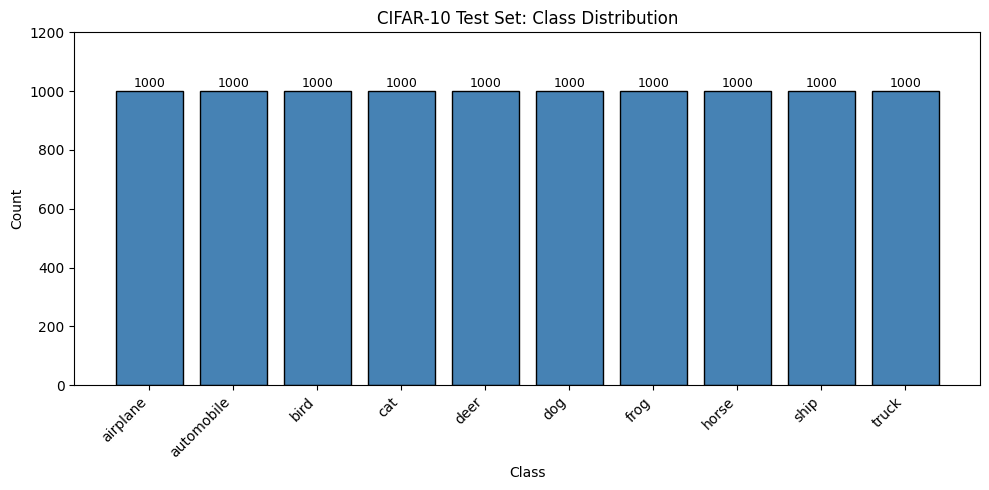


Perfectly balanced: 1000 - 1000 per class
Missing values: 0 (dataset is complete)
Duplicates: 0 (each image is unique)


In [4]:
# Class distribution
labels = [test_set_raw[i][1] for i in range(len(test_set_raw))]
class_names = test_set_raw.classes

fig, ax = plt.subplots(figsize=(10, 5))
counts = pd.Series(labels).value_counts().sort_index()
ax.bar(range(10), counts.values, color="steelblue", edgecolor="black")
ax.set_xticks(range(10))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_title("CIFAR-10 Test Set: Class Distribution")
ax.set_ylim(0, 1200)
for i, v in enumerate(counts.values):
    ax.text(i, v + 15, str(v), ha="center", fontsize=9)
plt.tight_layout()
plt.savefig("outputs/plots/cifar10_class_distribution.png", dpi=150)
plt.show()

print(f"\nPerfectly balanced: {counts.min()} - {counts.max()} per class")
print(f"Missing values: 0 (dataset is complete)")
print(f"Duplicates: 0 (each image is unique)")


### 2.2 Sample Images

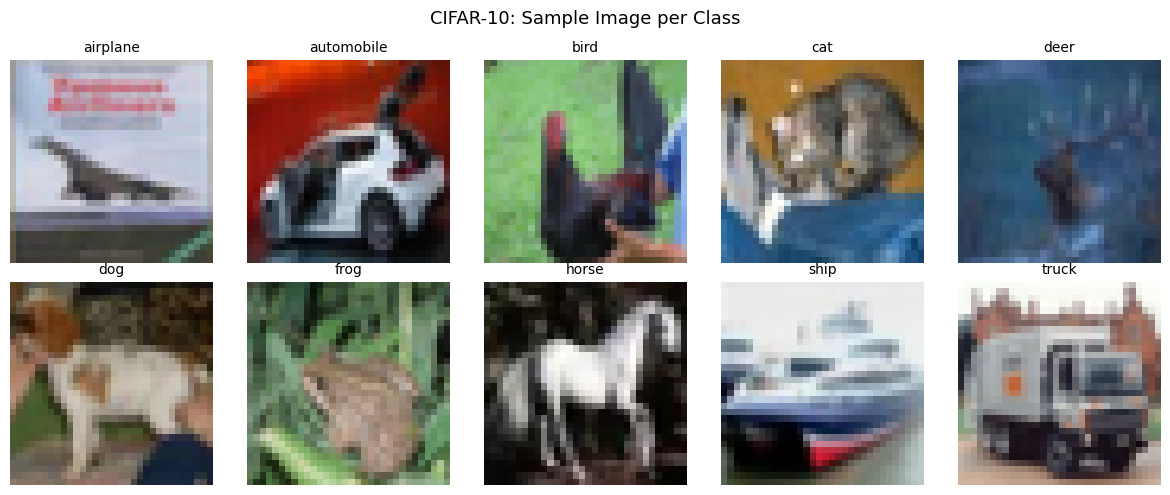

In [5]:
# Sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
class_indices = {i: None for i in range(10)}
for idx in range(len(test_set_raw)):
    _, label = test_set_raw[idx]
    if class_indices[label] is None:
        class_indices[label] = idx
    if all(v is not None for v in class_indices.values()):
        break

for i, ax in enumerate(axes.flat):
    img, label = test_set_raw[class_indices[i]]
    ax.imshow(img)
    ax.set_title(class_names[label], fontsize=10)
    ax.axis("off")

plt.suptitle("CIFAR-10: Sample Image per Class", fontsize=13)
plt.tight_layout()
plt.savefig("outputs/plots/sample_images.png", dpi=150)
plt.show()


### 2.3 Pixel Intensity Distribution

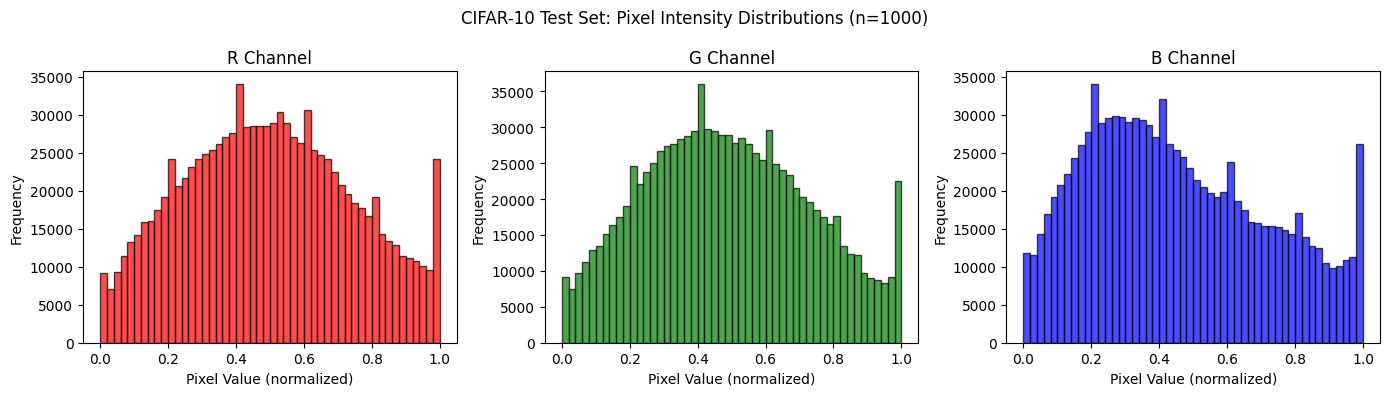

R channel — mean: 0.4967, std: 0.2466, min: 0.0000, max: 1.0000
G channel — mean: 0.4867, std: 0.2427, min: 0.0000, max: 1.0000
B channel — mean: 0.4510, std: 0.2617, min: 0.0000, max: 1.0000


In [6]:
# Pixel distributions across RGB channels (sample of 1000 images)
transform_raw = transforms.ToTensor()
test_set_tensor = datasets.CIFAR10(root="data/", train=False, download=True, transform=transform_raw)

pixels = {"R": [], "G": [], "B": []}
for i in range(1000):
    img, _ = test_set_tensor[i]
    pixels["R"].extend(img[0].flatten().numpy())
    pixels["G"].extend(img[1].flatten().numpy())
    pixels["B"].extend(img[2].flatten().numpy())

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
colors = ["red", "green", "blue"]
for ax, (channel, vals), color in zip(axes, pixels.items(), colors):
    ax.hist(vals, bins=50, color=color, alpha=0.7, edgecolor="black")
    ax.set_title(f"{channel} Channel")
    ax.set_xlabel("Pixel Value (normalized)")
    ax.set_ylabel("Frequency")
plt.suptitle("CIFAR-10 Test Set: Pixel Intensity Distributions (n=1000)")
plt.tight_layout()
plt.savefig("outputs/plots/pixel_distribution.png", dpi=150)
plt.show()

# Summary stats
for ch, vals in pixels.items():
    arr = np.array(vals)
    print(f"{ch} channel — mean: {arr.mean():.4f}, std: {arr.std():.4f}, min: {arr.min():.4f}, max: {arr.max():.4f}")


## 3. Model Training

ResNet-18 [He et al., 2016] adapted for CIFAR-10's 32×32 images:
- Modified first conv layer: 3×3 kernel, stride 1, padding 1 (instead of 7×7)
- Removed max pooling layer
- 20 epochs with SGD + cosine annealing

In [7]:
def build_resnet18(num_classes=10):
    """Build a ResNet-18 adapted for CIFAR-10 (32x32 images)."""
    model = models.resnet18(weights=None, num_classes=num_classes)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    return model

# Build model
model = build_resnet18(num_classes=10)
model.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Training loop
train_losses = []
train_accs = []

model.train()
for epoch in range(20):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Epoch {epoch+1:2d}/20 | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

# Save checkpoint
torch.save(model.state_dict(), CONFIG["model"]["checkpoint_path"])
print(f"\nModel saved to {CONFIG['model']['checkpoint_path']}")


Epoch  1/20 | Loss: 1.5638 | Acc: 42.26%
Epoch  2/20 | Loss: 1.0893 | Acc: 61.12%
Epoch  3/20 | Loss: 0.8678 | Acc: 69.37%
Epoch  4/20 | Loss: 0.7121 | Acc: 75.17%
Epoch  5/20 | Loss: 0.6260 | Acc: 78.14%
Epoch  6/20 | Loss: 0.5501 | Acc: 80.79%
Epoch  7/20 | Loss: 0.4883 | Acc: 82.91%
Epoch  8/20 | Loss: 0.4444 | Acc: 84.60%
Epoch  9/20 | Loss: 0.4098 | Acc: 85.72%
Epoch 10/20 | Loss: 0.3730 | Acc: 86.84%
Epoch 11/20 | Loss: 0.3367 | Acc: 88.26%
Epoch 12/20 | Loss: 0.3040 | Acc: 89.52%
Epoch 13/20 | Loss: 0.2798 | Acc: 90.31%
Epoch 14/20 | Loss: 0.2555 | Acc: 91.04%
Epoch 15/20 | Loss: 0.2309 | Acc: 92.14%
Epoch 16/20 | Loss: 0.2135 | Acc: 92.68%
Epoch 17/20 | Loss: 0.1952 | Acc: 93.33%
Epoch 18/20 | Loss: 0.1837 | Acc: 93.77%
Epoch 19/20 | Loss: 0.1776 | Acc: 93.92%
Epoch 20/20 | Loss: 0.1733 | Acc: 94.13%

Model saved to outputs/resnet18_cifar10.pth


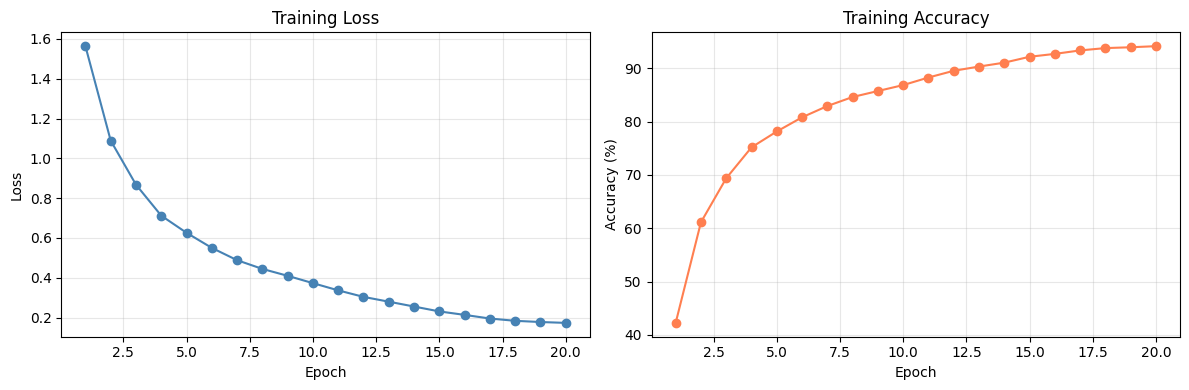

In [8]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(range(1, 21), train_losses, marker="o", color="steelblue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, 21), train_accs, marker="o", color="coral")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training Accuracy")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/plots/training_curves.png", dpi=150)
plt.show()


In [9]:
# Evaluate clean test accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

clean_acc = 100.0 * correct / total
print(f"Clean Test Accuracy: {clean_acc:.2f}%")


Clean Test Accuracy: 88.55%


## 4. Adversarial Attacks

Two attack methods implemented:
- **FGSM** [Goodfellow et al., 2015]: Single-step gradient attack
- **PGD** [Madry et al., 2018]: Multi-step iterative attack (stronger)

Each attack is run at 4 epsilon values: 0.01, 0.02, 0.04, 0.08

In [10]:
def fgsm_attack(model, images, labels, epsilon, device):
    """Fast Gradient Sign Method (FGSM)."""
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)

    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adv_images = images + perturbation
    return adv_images.detach()


def pgd_attack(model, images, labels, epsilon, alpha, steps, device):
    """Projected Gradient Descent (PGD) attack."""
    adv_images = images.clone().detach().to(device)
    original_images = images.clone().detach().to(device)
    labels = labels.to(device)

    # Random start within epsilon ball
    adv_images = adv_images + torch.empty_like(adv_images).uniform_(-epsilon, epsilon)

    for _ in range(steps):
        adv_images.requires_grad_(True)
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()

        adv_images = adv_images.detach() + alpha * adv_images.grad.sign()
        perturbation = torch.clamp(adv_images - original_images, -epsilon, epsilon)
        adv_images = original_images + perturbation

    return adv_images.detach()

print("Attack functions defined: fgsm_attack(), pgd_attack()")


Attack functions defined: fgsm_attack(), pgd_attack()


## 5. Generate Adversarial Telemetry

Run all attack configurations on the full CIFAR-10 test set.
Produces ~80,000 records (10,000 images × 2 attacks × 4 epsilons).

In [11]:
model.eval()
records = []
image_id_offset = 0

for batch_idx, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    batch_size = images.size(0)

    # Clean predictions
    with torch.no_grad():
        clean_outputs = model(images)
        clean_probs = F.softmax(clean_outputs, dim=1)
        clean_confs, clean_preds = clean_probs.max(dim=1)

    # Run each attack configuration
    for attack_cfg in CONFIG["attacks"]:
        attack_type = attack_cfg["type"]
        for epsilon in attack_cfg["epsilons"]:
            if attack_type == "fgsm":
                adv_images = fgsm_attack(model, images, labels, epsilon, device)
            elif attack_type == "pgd":
                adv_images = pgd_attack(
                    model, images, labels, epsilon,
                    alpha=attack_cfg["pgd_alpha"],
                    steps=attack_cfg["pgd_steps"],
                    device=device
                )

            # Adversarial predictions
            with torch.no_grad():
                adv_outputs = model(adv_images)
                adv_probs = F.softmax(adv_outputs, dim=1)
                adv_confs, adv_preds = adv_probs.max(dim=1)

            # L-inf norm of perturbation
            l_inf = (adv_images - images).abs().view(batch_size, -1).max(dim=1)[0]

            for i in range(batch_size):
                records.append({
                    "image_id": image_id_offset + i,
                    "true_label": labels[i].item(),
                    "clean_pred": clean_preds[i].item(),
                    "clean_conf": round(clean_confs[i].item(), 6),
                    "adv_pred": adv_preds[i].item(),
                    "adv_conf": round(adv_confs[i].item(), 6),
                    "flipped": int(clean_preds[i].item() != adv_preds[i].item()),
                    "attack_type": attack_type,
                    "epsilon": epsilon,
                    "l_inf_norm": round(l_inf[i].item(), 6),
                })

    image_id_offset += batch_size
    if image_id_offset % 2000 == 0:
        print(f"Processed {image_id_offset}/10000 images...")

# Save
telemetry_df = pd.DataFrame(records)
telemetry_df.to_csv(CONFIG["outputs"]["telemetry_path"], index=False)
print(f"\nTelemetry saved: {len(telemetry_df)} records → {CONFIG['outputs']['telemetry_path']}")


Processed 10000/10000 images...

Telemetry saved: 80000 records → outputs/adversarial_telemetry.csv


### 5.1 Telemetry Data Profile (Milestone 1 — Section 2.3)

In [12]:
print("=" * 65)
print("ADVERSARIAL TELEMETRY DATASET SUMMARY")
print("=" * 65)
print(f"Total records:   {len(telemetry_df)}")
print(f"Unique images:   {telemetry_df['image_id'].nunique()}")
print(f"Attack types:    {telemetry_df['attack_type'].unique().tolist()}")
print(f"Epsilon values:  {sorted(telemetry_df['epsilon'].unique().tolist())}")

print(f"\n--- Missing Values Per Column ---")
print(telemetry_df.isnull().sum().to_string())

print(f"\n--- Duplicate Rows ---")
print(f"Duplicates: {telemetry_df.duplicated().sum()}")

print(f"\n--- Numeric Summary Statistics ---")
print(telemetry_df[["clean_conf", "adv_conf", "l_inf_norm", "flipped"]].describe().round(4).to_string())

print(f"\n--- Schema ---")
print(telemetry_df.dtypes.to_string())

print(f"\n--- Sample Rows ---")
telemetry_df.head(5)


ADVERSARIAL TELEMETRY DATASET SUMMARY
Total records:   80000
Unique images:   10000
Attack types:    ['fgsm', 'pgd']
Epsilon values:  [0.01, 0.02, 0.04, 0.08]

--- Missing Values Per Column ---
image_id       0
true_label     0
clean_pred     0
clean_conf     0
adv_pred       0
adv_conf       0
flipped        0
attack_type    0
epsilon        0
l_inf_norm     0

--- Duplicate Rows ---
Duplicates: 0

--- Numeric Summary Statistics ---
       clean_conf    adv_conf  l_inf_norm     flipped
count  80000.0000  80000.0000  80000.0000  80000.0000
mean       0.9226      0.8838      0.0375      0.4883
std        0.1456      0.1606      0.0268      0.4999
min        0.2345      0.1950      0.0100      0.0000
25%        0.9303      0.8154      0.0175      0.0000
50%        0.9970      0.9707      0.0300      0.0000
75%        0.9999      0.9981      0.0500      1.0000
max        1.0000      1.0000      0.0800      1.0000

--- Schema ---
image_id         int64
true_label       int64
clean_pred    

,image_id,true_label,clean_pred,clean_conf,adv_pred,adv_conf,flipped,attack_type,epsilon,l_inf_norm
0,0,3,3,0.995059,3,0.971323,0,fgsm,0.01,0.01
1,1,8,8,0.999894,8,0.998805,0,fgsm,0.01,0.01
2,2,8,8,0.989070,8,0.685593,0,fgsm,0.01,0.01
3,3,0,8,0.678267,8,0.978311,0,fgsm,0.01,0.01
4,4,6,6,0.999977,6,0.999734,0,fgsm,0.01,0.01


## 6. Feature Engineering

Compute robustness features from telemetry:
- Accuracy-based: clean accuracy, adversarial accuracy, accuracy drop
- Confidence-based: mean confidence, confidence drop, variance
- Attack success: ASR, per-class ASR, worst-class ASR
- Sensitivity: robustness decay rate (slope of accuracy vs epsilon)

In [13]:
# Aggregate features per (attack_type, epsilon)
features = []

for (attack_type, epsilon), group in telemetry_df.groupby(["attack_type", "epsilon"]):
    n = len(group)

    clean_correct = (group["true_label"] == group["clean_pred"]).sum()
    adv_correct = (group["true_label"] == group["adv_pred"]).sum()
    clean_acc = clean_correct / n
    adv_acc = adv_correct / n
    acc_drop = clean_acc - adv_acc

    mean_clean_conf = group["clean_conf"].mean()
    mean_adv_conf = group["adv_conf"].mean()
    conf_drop = mean_clean_conf - mean_adv_conf
    adv_conf_std = group["adv_conf"].std()

    asr = group["flipped"].mean()
    class_asr = group.groupby("true_label")["flipped"].mean()
    worst_class_asr = class_asr.max()
    best_class_asr = class_asr.min()
    asr_std = class_asr.std()

    mean_l_inf = group["l_inf_norm"].mean()

    features.append({
        "attack_type": attack_type,
        "epsilon": epsilon,
        "clean_accuracy": round(clean_acc, 6),
        "adversarial_accuracy": round(adv_acc, 6),
        "accuracy_drop": round(acc_drop, 6),
        "mean_clean_confidence": round(mean_clean_conf, 6),
        "mean_adv_confidence": round(mean_adv_conf, 6),
        "confidence_drop": round(conf_drop, 6),
        "adv_confidence_std": round(adv_conf_std, 6),
        "attack_success_rate": round(asr, 6),
        "worst_class_asr": round(worst_class_asr, 6),
        "best_class_asr": round(best_class_asr, 6),
        "class_asr_std": round(asr_std, 6),
        "mean_l_inf_norm": round(mean_l_inf, 6),
        "num_samples": n,
    })

features_df = pd.DataFrame(features)
features_df.to_csv(CONFIG["outputs"]["features_path"], index=False)

print("Robustness Features:")
features_df


Robustness Features:


,attack_type,epsilon,clean_accuracy,adversarial_accuracy,accuracy_drop,mean_clean_confidence,mean_adv_confidence,confidence_drop,adv_confidence_std,attack_success_rate,worst_class_asr,best_class_asr,class_asr_std,mean_l_inf_norm,num_samples
0,fgsm,0.01,0.8855,0.7306,0.1549,0.922582,0.880095,0.042487,0.166070,0.1580,0.258,0.072,0.063777,0.01,10000
1,fgsm,0.02,0.8855,0.5495,0.3360,0.922582,0.860582,0.062000,0.170477,0.3405,0.474,0.200,0.097698,0.02,10000
2,fgsm,0.04,0.8855,0.2898,0.5957,0.922582,0.858744,0.063838,0.172132,0.6010,0.737,0.460,0.096062,0.04,10000
3,fgsm,0.08,0.8855,0.0967,0.7888,0.922582,0.879392,0.043191,0.169676,0.7957,0.890,0.650,0.067809,0.08,10000
4,pgd,0.01,0.8855,0.7082,0.1773,0.922582,0.884747,0.037835,0.158078,0.1817,0.306,0.080,0.073731,0.01,10000
5,pgd,0.02,0.8855,0.4751,0.4104,0.922582,0.880110,0.042472,0.155608,0.4161,0.558,0.245,0.108575,0.02,10000
6,pgd,0.04,0.8855,0.2346,0.6509,0.922582,0.903307,0.019275,0.144943,0.6582,0.807,0.501,0.089262,0.04,10000
7,pgd,0.08,0.8855,0.1386,0.7469,0.922582,0.923306,-0.000724,0.133995,0.7551,0.859,0.641,0.061661,0.08,10000


In [14]:
# Per-class features
class_features = []
for (attack_type, epsilon, label), group in telemetry_df.groupby(
    ["attack_type", "epsilon", "true_label"]
):
    class_features.append({
        "attack_type": attack_type,
        "epsilon": epsilon,
        "true_label": label,
        "class_clean_acc": round((group["true_label"] == group["clean_pred"]).mean(), 4),
        "class_adv_acc": round((group["true_label"] == group["adv_pred"]).mean(), 4),
        "class_asr": round(group["flipped"].mean(), 4),
        "class_mean_adv_conf": round(group["adv_conf"].mean(), 4),
        "num_samples": len(group),
    })

class_features_df = pd.DataFrame(class_features)
class_features_df.to_csv(CONFIG["outputs"]["features_path"].replace(".csv", "_per_class.csv"), index=False)

# Robustness decay rate
decay_rates = []
for attack_type, group in features_df.groupby("attack_type"):
    group = group.sort_values("epsilon")
    slope = np.polyfit(group["epsilon"].values, group["adversarial_accuracy"].values, 1)[0]
    decay_rates.append({"attack_type": attack_type, "decay_rate": round(slope, 4)})

decay_df = pd.DataFrame(decay_rates)
decay_df.to_csv(CONFIG["outputs"]["features_path"].replace(".csv", "_decay.csv"), index=False)

print("Robustness Decay Rates:")
print(decay_df.to_string(index=False))


Robustness Decay Rates:
attack_type  decay_rate
       fgsm     -8.6517
        pgd     -7.4131


## 7. Risk Scoring & Deploy Gate

Composite **Robustness Risk Score** = weighted combination of:
- Accuracy drop (35%)
- Confidence drop (25%)
- Attack success rate (25%)
- Worst-class ASR (15%)

Deploy gate: **BLOCK** if risk score > 0.5

In [15]:
weights = CONFIG["risk_scoring"]["weights"]
threshold = CONFIG["risk_scoring"]["deploy_threshold"]

risk_records = []
for _, row in features_df.iterrows():
    norm_acc_drop = min(row["accuracy_drop"], 1.0)
    norm_conf_drop = min(max(row["confidence_drop"], 0.0), 1.0)
    asr = row["attack_success_rate"]
    worst_asr = row["worst_class_asr"]

    risk_score = (
        weights["accuracy_drop"] * norm_acc_drop
        + weights["confidence_drop"] * norm_conf_drop
        + weights["attack_success_rate"] * asr
        + weights["worst_class_asr"] * worst_asr
    )

    risk_records.append({
        "attack_type": row["attack_type"],
        "epsilon": row["epsilon"],
        "accuracy_drop": row["accuracy_drop"],
        "confidence_drop": row["confidence_drop"],
        "attack_success_rate": asr,
        "worst_class_asr": worst_asr,
        "risk_score": round(risk_score, 6),
    })

risk_df = pd.DataFrame(risk_records)
risk_df["gate_decision"] = risk_df["risk_score"].apply(lambda s: "BLOCK" if s > threshold else "PASS")
risk_df.to_csv(CONFIG["outputs"]["risk_report_path"], index=False)

# Print risk report
print("=" * 72)
print("ROBUSTOPS RISK REPORT")
print("=" * 72)
print(f"Model: ResNet-18 on CIFAR-10 | Deploy Threshold: {threshold}")
print("-" * 72)

for _, row in risk_df.iterrows():
    gate = row["gate_decision"]
    marker = "PASS" if gate == "PASS" else "BLOCK"
    print(
        f"  [{marker:5s}] {row['attack_type'].upper():4s} eps={row['epsilon']:.3f} | "
        f"Risk: {row['risk_score']:.4f} | "
        f"ASR: {row['attack_success_rate']:.3f} | "
        f"AccDrop: {row['accuracy_drop']:.3f}"
    )

print("-" * 72)
max_risk = risk_df["risk_score"].max()
overall = "BLOCK" if max_risk > threshold else "PASS"
print(f"  Overall Max Risk: {max_risk:.4f} --> {overall}")
print("=" * 72)


ROBUSTOPS RISK REPORT
Model: ResNet-18 on CIFAR-10 | Deploy Threshold: 0.5
------------------------------------------------------------------------
  [PASS ] FGSM eps=0.010 | Risk: 0.1430 | ASR: 0.158 | AccDrop: 0.155
  [PASS ] FGSM eps=0.020 | Risk: 0.2893 | ASR: 0.341 | AccDrop: 0.336
  [PASS ] FGSM eps=0.040 | Risk: 0.4853 | ASR: 0.601 | AccDrop: 0.596
  [BLOCK] FGSM eps=0.080 | Risk: 0.6193 | ASR: 0.796 | AccDrop: 0.789
  [PASS ] PGD  eps=0.010 | Risk: 0.1628 | ASR: 0.182 | AccDrop: 0.177
  [PASS ] PGD  eps=0.020 | Risk: 0.3420 | ASR: 0.416 | AccDrop: 0.410
  [BLOCK] PGD  eps=0.040 | Risk: 0.5182 | ASR: 0.658 | AccDrop: 0.651
  [BLOCK] PGD  eps=0.080 | Risk: 0.5790 | ASR: 0.755 | AccDrop: 0.747
------------------------------------------------------------------------
  Overall Max Risk: 0.6193 --> BLOCK


## 8. Adversarial Analysis Plots

/tmp/ipython-input-3071539156.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_acc = telemetry_df.groupby(["attack_type", "epsilon"]).apply(


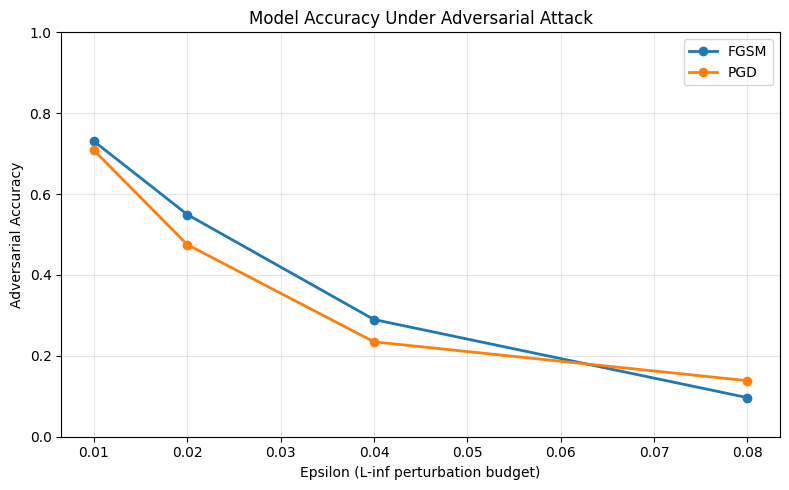

In [16]:
# Adversarial accuracy vs epsilon
summary_acc = telemetry_df.groupby(["attack_type", "epsilon"]).apply(
    lambda g: (g["true_label"] == g["adv_pred"]).mean()
).reset_index(name="adv_accuracy")

fig, ax = plt.subplots(figsize=(8, 5))
for attack_type, group in summary_acc.groupby("attack_type"):
    group = group.sort_values("epsilon")
    ax.plot(group["epsilon"], group["adv_accuracy"], marker="o", linewidth=2, label=attack_type.upper())

ax.set_xlabel("Epsilon (L-inf perturbation budget)")
ax.set_ylabel("Adversarial Accuracy")
ax.set_title("Model Accuracy Under Adversarial Attack")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig("outputs/plots/adversarial_accuracy.png", dpi=150)
plt.show()


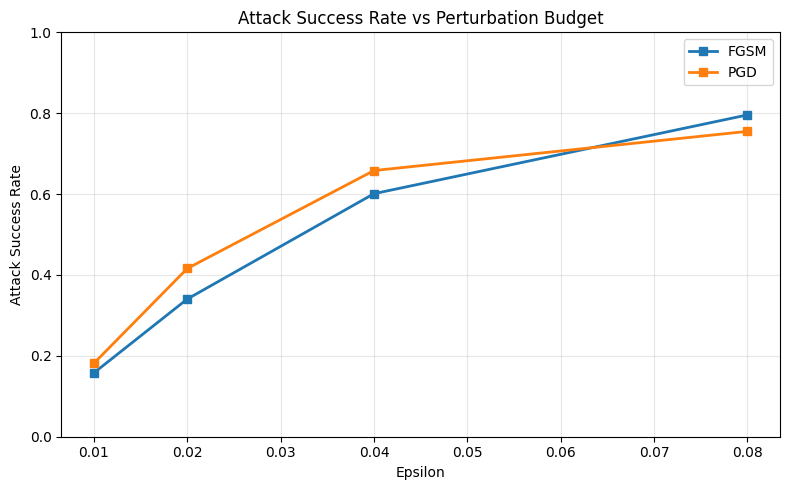

In [17]:
# Attack success rate vs epsilon
summary_asr = telemetry_df.groupby(["attack_type", "epsilon"])["flipped"].mean().reset_index(name="asr")

fig, ax = plt.subplots(figsize=(8, 5))
for attack_type, group in summary_asr.groupby("attack_type"):
    group = group.sort_values("epsilon")
    ax.plot(group["epsilon"], group["asr"], marker="s", linewidth=2, label=attack_type.upper())

ax.set_xlabel("Epsilon")
ax.set_ylabel("Attack Success Rate")
ax.set_title("Attack Success Rate vs Perturbation Budget")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig("outputs/plots/attack_success_rate.png", dpi=150)
plt.show()


/tmp/ipython-input-2547530972.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conf_drop = subset.groupby("attack_type").apply(


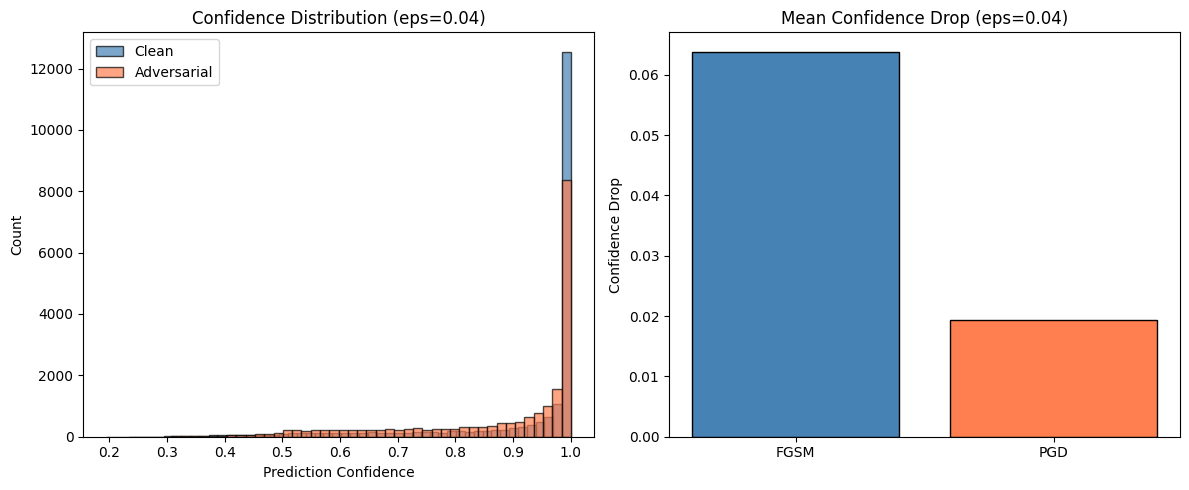

In [18]:
# Confidence distribution: clean vs adversarial (at eps=0.04)
subset = telemetry_df[telemetry_df["epsilon"] == 0.04]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(subset["clean_conf"], bins=50, color="steelblue", alpha=0.7, edgecolor="black", label="Clean")
axes[0].hist(subset["adv_conf"], bins=50, color="coral", alpha=0.7, edgecolor="black", label="Adversarial")
axes[0].set_title("Confidence Distribution (eps=0.04)")
axes[0].set_xlabel("Prediction Confidence")
axes[0].set_ylabel("Count")
axes[0].legend()

conf_drop = subset.groupby("attack_type").apply(
    lambda g: g["clean_conf"].mean() - g["adv_conf"].mean()
).reset_index(name="conf_drop")
axes[1].bar(conf_drop["attack_type"].str.upper(), conf_drop["conf_drop"],
            color=["steelblue", "coral"], edgecolor="black")
axes[1].set_title("Mean Confidence Drop (eps=0.04)")
axes[1].set_ylabel("Confidence Drop")

plt.tight_layout()
plt.savefig("outputs/plots/confidence_distribution.png", dpi=150)
plt.show()


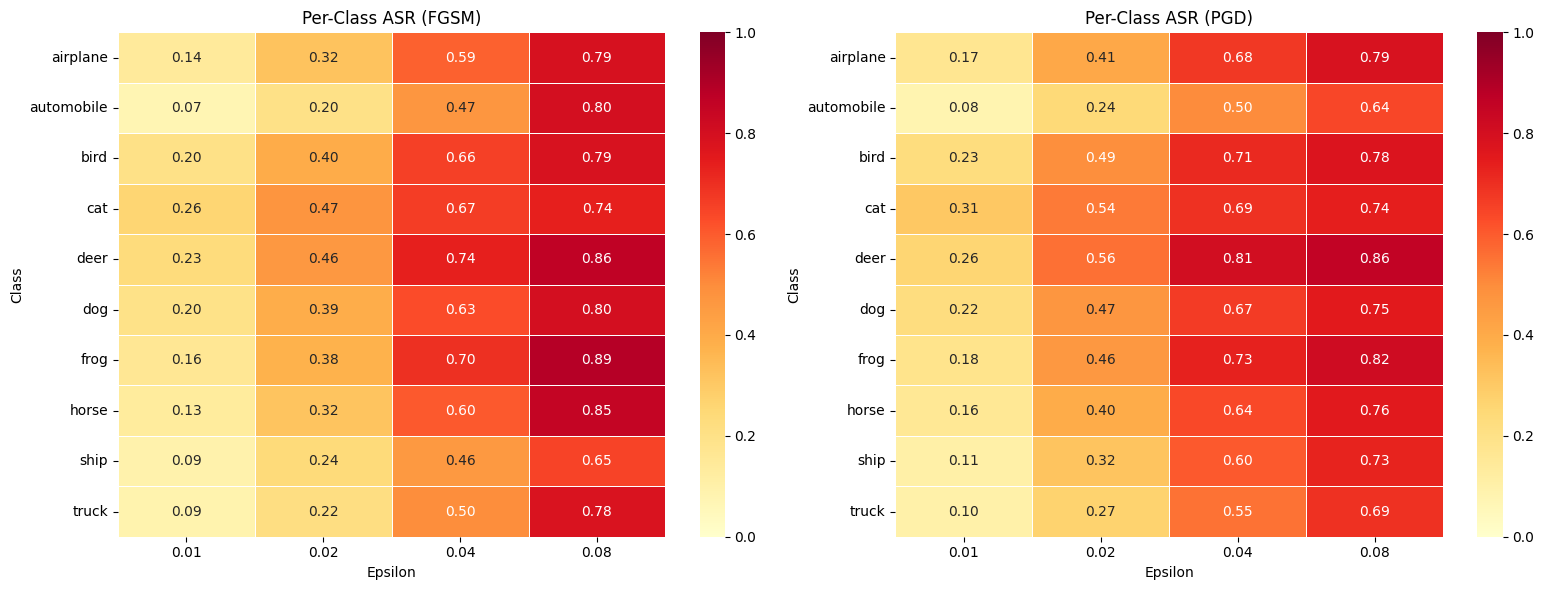

In [19]:
# Per-class ASR heatmaps
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, attack_type in enumerate(telemetry_df["attack_type"].unique()):
    subset = telemetry_df[telemetry_df["attack_type"] == attack_type]
    pivot = subset.pivot_table(values="flipped", index="true_label", columns="epsilon", aggfunc="mean")
    pivot.index = [class_names[i] for i in pivot.index]

    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrRd",
                ax=axes[idx], vmin=0, vmax=1, linewidths=0.5)
    axes[idx].set_title(f"Per-Class ASR ({attack_type.upper()})")
    axes[idx].set_xlabel("Epsilon")
    axes[idx].set_ylabel("Class")

plt.tight_layout()
plt.savefig("outputs/plots/class_asr_heatmaps.png", dpi=150)
plt.show()


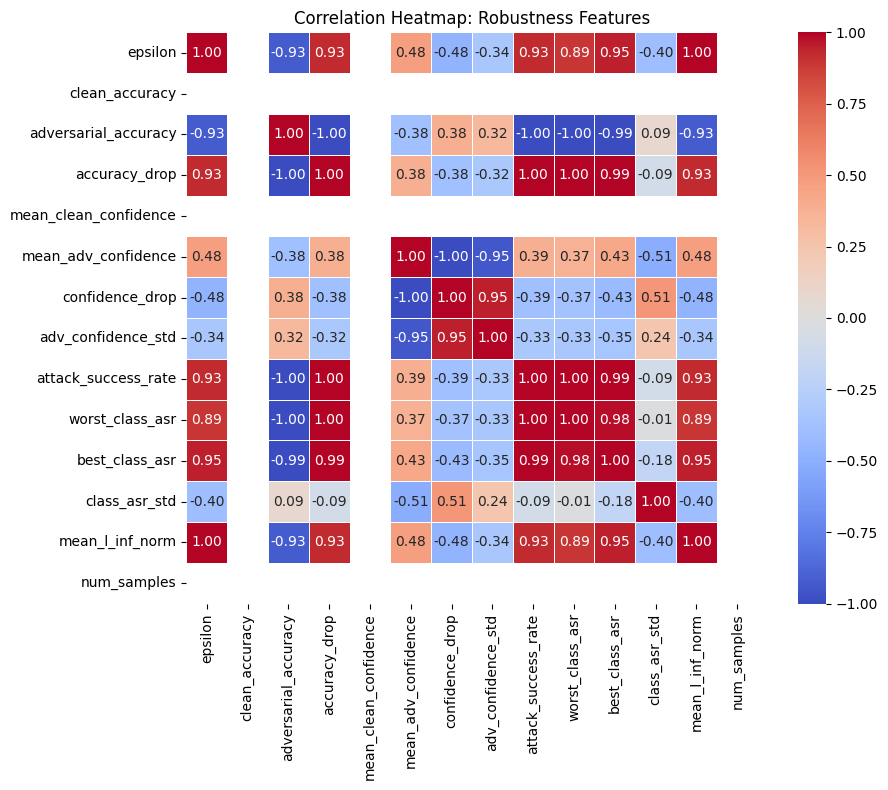

In [20]:
# Feature correlation heatmap
numeric_cols = features_df.select_dtypes(include=[np.number]).columns
corr = features_df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
            ax=ax, center=0, linewidths=0.5, square=True)
ax.set_title("Correlation Heatmap: Robustness Features")
plt.tight_layout()
plt.savefig("outputs/plots/feature_correlation.png", dpi=150)
plt.show()


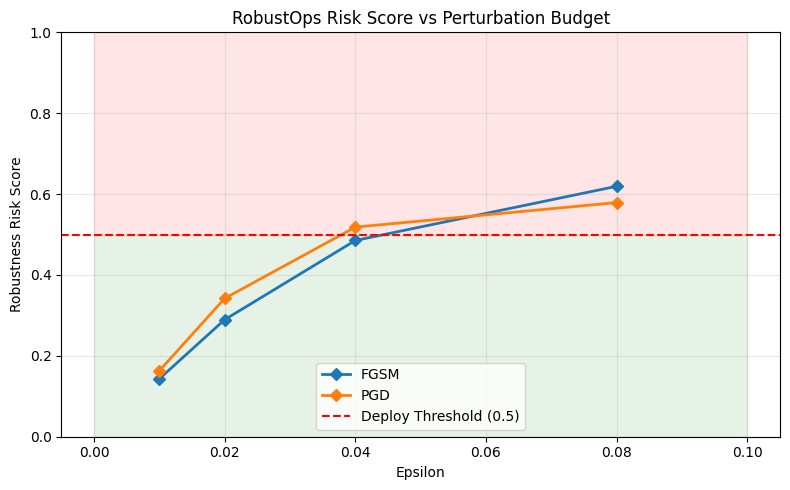

In [21]:
# Risk score visualization
fig, ax = plt.subplots(figsize=(8, 5))

for attack_type, group in risk_df.groupby("attack_type"):
    group = group.sort_values("epsilon")
    ax.plot(group["epsilon"], group["risk_score"], marker="D", linewidth=2, label=attack_type.upper())

ax.axhline(y=threshold, color="red", linestyle="--", linewidth=1.5, label=f"Deploy Threshold ({threshold})")
ax.fill_between([0, 0.1], threshold, 1.0, alpha=0.1, color="red")
ax.fill_between([0, 0.1], 0, threshold, alpha=0.1, color="green")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Robustness Risk Score")
ax.set_title("RobustOps Risk Score vs Perturbation Budget")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig("outputs/plots/risk_scores.png", dpi=150)
plt.show()


## 9. Output Summary

All outputs saved to `outputs/`:

| File | Description |
|------|-------------|
| `resnet18_cifar10.pth` | Trained model checkpoint |
| `adversarial_telemetry.csv` | Raw per-sample attack results (~80K rows) |
| `robustness_features.csv` | Aggregated robustness metrics per attack config |
| `robustness_features_per_class.csv` | Per-class robustness breakdown |
| `robustness_features_decay.csv` | Robustness decay rates |
| `risk_report.csv` | Final risk scores with gate decisions |
| `plots/` | All visualization plots |

In [22]:
# List all outputs
print("Generated outputs:")
for root, dirs, files in os.walk("outputs"):
    for f in sorted(files):
        path = os.path.join(root, f)
        size = os.path.getsize(path)
        if size > 1024*1024:
            print(f"  {path} ({size/1024/1024:.1f} MB)")
        elif size > 1024:
            print(f"  {path} ({size/1024:.1f} KB)")
        else:
            print(f"  {path} ({size} B)")


Generated outputs:
  outputs/adversarial_telemetry.csv (3.4 MB)
  outputs/resnet18_cifar10.pth (42.7 MB)
  outputs/risk_report.csv (527 B)
  outputs/robustness_features.csv (1.0 KB)
  outputs/robustness_features_decay.csv (48 B)
  outputs/robustness_features_per_class.csv (3.3 KB)
  outputs/plots/adversarial_accuracy.png (67.4 KB)
  outputs/plots/attack_success_rate.png (56.6 KB)
  outputs/plots/cifar10_class_distribution.png (48.2 KB)
  outputs/plots/class_asr_heatmaps.png (137.8 KB)
  outputs/plots/confidence_distribution.png (65.5 KB)
  outputs/plots/feature_correlation.png (241.5 KB)
  outputs/plots/pixel_distribution.png (71.2 KB)
  outputs/plots/risk_scores.png (57.9 KB)
  outputs/plots/sample_images.png (72.5 KB)
  outputs/plots/training_curves.png (61.6 KB)
